In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.19.0


In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arar
from skforecast.recursive import ForecasterStats, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.19.0


# Fuel consumption dataset

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-04-01,202319.8164,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-05-01,206259.1523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-09-01,687649.2852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1989-10-01,669889.1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1989-11-01,601413.8867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


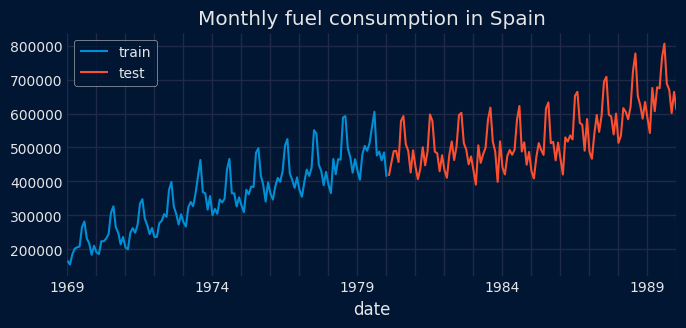

In [4]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [5]:
# Backtesting ForecasterStats with sarimax statsmodels with exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )

start = timeit.default_timer()
metric_sarimax_exog, pred_sarimax_exog = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    exog       = data.drop(columns='y'),
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_sarimax_exog = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
# Backtesting ForecasterStats with ARAR skforecast no exog
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 estimator=Arar(max_ar_depth=24, max_lag=24)
             )

start = timeit.default_timer()
metric_arar, pred_arar = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    exog       = None,
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arar = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# Backtesting ForecasterStats with ARAR skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True
)
forecaster = ForecasterStats(
                 estimator=Arar(max_ar_depth=24, max_lag=24)
             )

start = timeit.default_timer()
metric_arar_exog, pred_arar_exog = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    exog       = data.drop(columns=['y']),
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arar_exog = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# Backtesting ForecasterStats with sklearn Ridge
# ==============================================================================
params = {'alpha': 0.001}
forecaster = ForecasterRecursive(
                 estimator     = Ridge(**params, random_state=123),
                 lags          = 12,
                 transformer_y = StandardScaler(),
             )

start = timeit.default_timer()
metric_ridge, predictions_ridge = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['y'],
    exog       = data.drop(columns=['y']),
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ridge = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Sarimax Exogenous",
            "ARAR skforecast",
            "ARAR skforecast exog",
            "Ridge sklearn",
        ],
        "MAE": [
            metric_sarimax_exog.at[0, "mean_absolute_error"],
            metric_arar.at[0, "mean_absolute_error"],
            metric_arar_exog.at[0, "mean_absolute_error"],
            metric_ridge.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_sarimax_exog,
            elapsed_time_arar,
            elapsed_time_arar_exog,
            elapsed_time_ridge,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,Sarimax Exogenous,20528.190756,14.718588
1,Ridge sklearn,21419.749405,0.082622
2,ARAR skforecast,27534.082931,0.691603
3,ARAR skforecast exog,31073.842467,0.802658


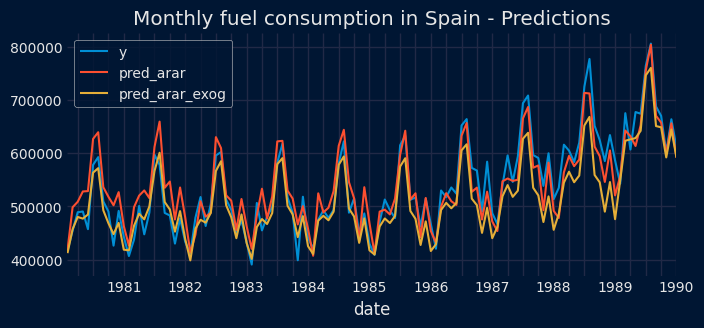

In [10]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_arar['pred'].plot(ax=ax, label='pred_arar')
pred_arar_exog['pred'].plot(ax=ax, label='pred_arar_exog')
#predictions_ridge['pred'].plot(ax=ax, label='pred_ridge')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();

# Web traffic dataset

In [11]:
# Data downloading
# ==============================================================================
data = fetch_dataset(name="website_visits", raw=True, verbose=False)
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%y')
data = data.set_index('date')
data = data.asfreq('1D')
data = data.sort_index()

In [12]:
# Features based on calendar
# ==============================================================================
data['month'] = data.index.month
data['month_day'] = data.index.day
data['week_day'] = data.index.day_of_week

# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        ['month', 'week_day', 'month_day'],
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

data = one_hot_encoder.fit_transform(data)
data.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_day_23,month_day_24,month_day_25,month_day_26,month_day_27,month_day_28,month_day_29,month_day_30,month_day_31,users
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2324
2020-07-02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2201
2020-07-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2146


Training dates   : 2020-07-01 00:00:00 --- 2021-03-30 00:00:00  (n=273)
Test dates       : 2021-03-31 00:00:00 --- 2021-08-25 00:00:00  (n=148)


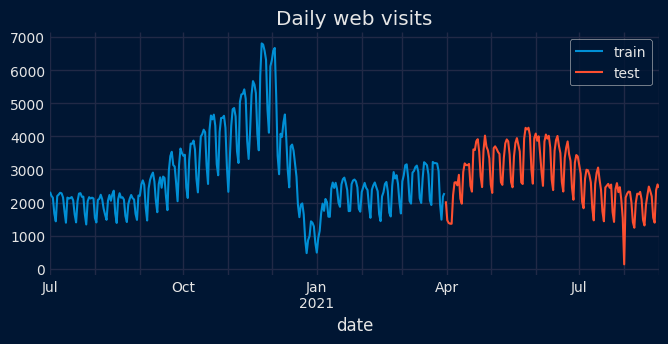

In [13]:
# Split data train-val-test
# ==============================================================================
end_train = '2021-03-30 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]
exog_features = [col for col in data.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]
print(f"Training dates   : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['users'].plot(ax=ax, label='train')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Daily web visits')
ax.legend();

In [14]:
# Backtesting ForecasterStats with ARAR skforecast no exog
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 7,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
      )
forecaster = ForecasterStats(
                 estimator=Arar(max_ar_depth=24, max_lag=24)
             )

start = timeit.default_timer()
metric_arar, pred_arar = backtesting_stats(
    forecaster = forecaster,
    y          = data['users'],
    exog       = None,
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arar = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [15]:
# Backtesting ForecasterStats with ARAR skforecast with exog
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 7,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
      )
forecaster = ForecasterStats(
                 estimator=Arar(max_ar_depth=24, max_lag=24)
             )

start = timeit.default_timer()
metric_arar_exog, pred_arar_exog = backtesting_stats(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[exog_features],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arar_exog = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [16]:
# Backtesting ForecasterStats with sklearn Ridge
# ==============================================================================
params = {'alpha': np.float64(2.154434690031882)}
forecaster = ForecasterRecursive(
                 estimator     = Ridge(**params, random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler(),
                 forecaster_id = 'web_traffic'
             )

start = timeit.default_timer()
metric_ridge, predictions_ridge = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[exog_features],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ridge = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [17]:
# Backtesting ForecasterStats with sarimax statsmodels
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), maxiter=500),
             )

start = timeit.default_timer()
metric_sarimax, pred_sarimax = backtesting_stats(
    forecaster = forecaster,
    y          = data['users'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_sarimax = stop - start

  0%|          | 0/22 [00:00<?, ?it/s]

In [18]:
# Backtesting ForecasterStats with sarimax statsmodels with exogenous variables
# ==============================================================================
# forecaster = ForecasterStats(
#                  estimator=Sarimax(order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), maxiter=500),
#              )
# start = timeit.default_timer()
# metric_sarimax_exog, pred_sarimax_exog = backtesting_stats(
#                     forecaster = forecaster,
#                     y          = data['users'],
#                     exog       = data.drop(columns='users'),
#                     cv         = cv,
#                     metric     = 'mean_absolute_error'
#                 )
# stop = timeit.default_timer()
# elapsed_time_sarimax_exog = stop - start

In [19]:
results = pd.DataFrame(
    {
        "Model": [
            "ARAR skforecast",
            "ARAR skforecast Exogenous",
            "sklearn Ridge",
            "SARIMAX statsmodels",
            # "SARIMAX statsmodels Exogenous",
        ],
        "MAE": [
            metric_arar.at[0, "mean_absolute_error"],
            metric_arar_exog.at[0, "mean_absolute_error"],
            metric_ridge.at[0, "mean_absolute_error"],
            metric_sarimax.at[0, "mean_absolute_error"],
            # metric_sarimax_exog.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_arar,
            elapsed_time_arar_exog,
            elapsed_time_ridge,
            elapsed_time_sarimax,
            # elapsed_time_sarimax_exog,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,sklearn Ridge,180.156629,0.250802
1,SARIMAX statsmodels,217.206636,59.209522
2,ARAR skforecast,237.564165,1.589663
3,ARAR skforecast Exogenous,294.063545,2.168900


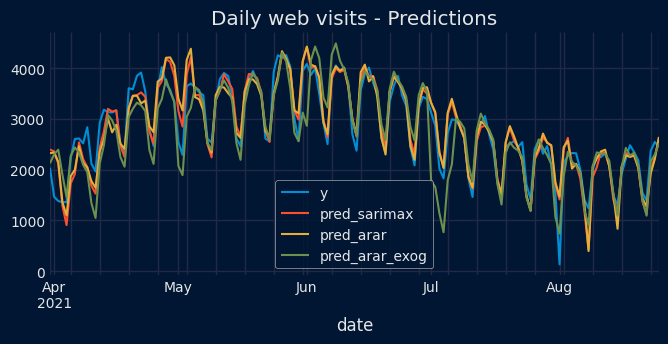

In [20]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['users'].loc[data_test.index].plot(ax=ax, label='y')
pred_sarimax['pred'].plot(ax=ax, label='pred_sarimax')
pred_arar['pred'].plot(ax=ax, label='pred_arar')
pred_arar_exog['pred'].plot(ax=ax, label='pred_arar_exog')
#predictions_ridge['pred'].plot(ax=ax, label='pred_ridge')
ax.set_title('Daily web visits - Predictions')
ax.legend();

## Electricity consumption in Spain

In [21]:
# Data downloading
# ==============================================================================
data = fetch_dataset(name="vic_electricity", raw=False, verbose=False)

# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
data = data.drop(columns="Date")
data = (
    data
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)

data.head(3)

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0


In [22]:
data = data.loc['2012-01-01 00:00:00':'2014-12-30 23:00:00', :].copy()
end_train = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()
print(f"Training dates   : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Training dates   : 2012-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=25560)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


In [23]:
# Backtesting ForecasterStats with ARAR skforecast no exog
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
      )
forecaster = ForecasterStats(
                 estimator=Arar(max_ar_depth=72, max_lag=72)
             )

start = timeit.default_timer()
metric_arar, pred_arar = backtesting_stats(
    forecaster = forecaster,
    y          = data['Demand'],
    exog       = None,
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arar = stop - start

  0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
# Backtesting ForecasterStats with ARAR skforecast with exog
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
      )
forecaster = ForecasterStats(
                 estimator=Arar(max_ar_depth=72, max_lag=72)
             )

start = timeit.default_timer()
metric_arar_exog, pred_arar_exog = backtesting_stats(
    forecaster = forecaster,
    y          = data['Demand'],
    exog       = data[['Temperature', 'Holiday']],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arar_exog = stop - start

  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
results = pd.DataFrame(
    {
        "Model": [
            "ARAR skforecast",
            "ARAR skforecast Exogenous",
        ],
        "MAE": [
            metric_arar.at[0, "mean_absolute_error"],
            metric_arar_exog.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_arar,
            elapsed_time_arar_exog
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,ARAR skforecast Exogenous,236.277997,63.771725
1,ARAR skforecast,318.808227,68.689184
